In [ ]:
# Colab: install all dependencies
!pip -q install --upgrade pip
!pip -q install roboflow networkx svgwrite numpy pillow opencv-python python-dotenv


Generated single stroke SVG: out/lsystem_single_stroke.svg


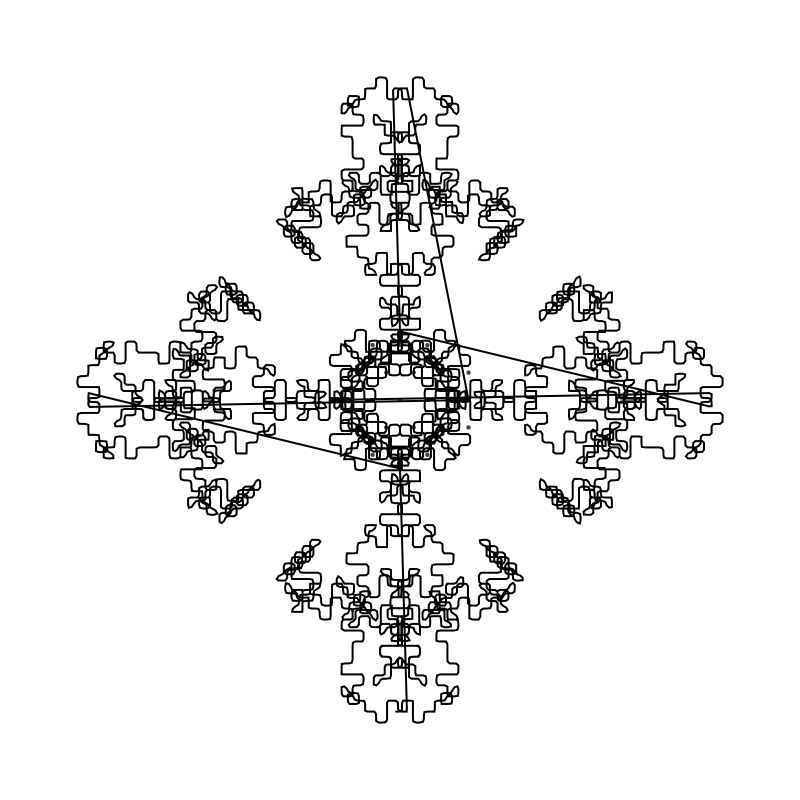

In [ ]:
# Reuse functions from previous cells:
# kolam_lsystem
# KolamParams
# generate_kolam
# to_svg
# display (from IPython.display)
# SVG (from IPython.display)
# Path (from pathlib)

# Define parameters for L-system generation
# You can adjust these parameters to get different designs
params = KolamParams(
    rows=5, cols=5, grid_kind="diamond",
    step=8.0, lsys_iters=3,
    symmetry_k=4, symmetry_mirror=True,
    add_ifs=False, # Set to False for a simpler single stroke without IFS decorations
    resample_step=2.5
)

# Generate the kolam using the L-system
# The first element of the returned polys is the main L-system stroke
polys, dots, stat, D = generate_kolam(params)

# The L-system turtle function returns a single list of points for the main stroke.
# Ensure we are only drawing this main stroke as the single line.
single_stroke_poly = polys[0] if polys else [] # Take the first polygon (the L-system path)

# Define the output filename
output_svg_file = "out/lsystem_single_stroke.svg"

# Draw the single stroke using to_svg
# Pass only the single stroke polygon to the polys list
if single_stroke_poly:
    to_svg(polys=[single_stroke_poly], dots=dots, filename=output_svg_file, stroke="#000")
    print(f"Generated single stroke SVG: {output_svg_file}")
    # Display the generated SVG
    display(SVG(filename=output_svg_file))
else:
    print("Could not generate L-system path with current parameters.")

In [ ]:
import networkx as nx
from typing import List
from pathlib import Path # Import Path
from IPython.display import SVG, display
from collections import defaultdict
import numpy as np # Import numpy
from PIL import Image # Import PIL for image loading
import cv2 # Import cv2 for image processing
import svgwrite # Import svgwrite for SVG generation


# Reuse functions defined in previous cells:
# load_and_preprocess_kolam # This function will be slightly modified here to use local imports
# path_graph # Not directly used in the new logic, but available
# eulerian_status # Not directly used in the new logic, but available
# to_svg
# quantize # Needed by path_graph, but also used here
# resample_poly # Added for smoothing

def list_images(root: Path):
    """Lists image files in a directory with common image extensions."""
    exts={".jpg",".jpeg",".png",".bmp",".tif",".tiff"}
    return [p for p in root.rglob("*") if p.suffix.lower() in exts]

def load_and_preprocess_kolam(image_path: Path, size=384):
    """Loads a kolam image, converts to grayscale, resizes, and performs edge detection."""
    try:
        img = Image.open(image_path).convert("L").resize((size, size))
        img_np = np.array(img).astype(np.uint8)
        edges = cv2.Canny(img_np, 60, 160) # Edge detection
        ys, xs = np.where(edges > 0)
        # Store as complex points, potentially adding an identifier for the image
        points = [complex(float(x), float(y)) for x, y in zip(xs, ys)]
        return points
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None


def find_eulerian_path_or_circuit(graph: nx.Graph):
    """Finds an Eulerian path or circuit in a graph if one exists."""
    # Ensure the graph is not empty
    if not graph or graph.number_of_nodes() == 0:
        print("Graph is empty.")
        return None, "none", graph

    # Check if the graph is connected
    if not nx.is_connected(graph):
        print("Graph is not connected. Analyzing largest connected component.")
        components = list(nx.connected_components(graph))
        if not components:
            print("No connected components found.")
            return None, "none", graph
        largest_component_nodes = max(components, key=len)
        subgraph = graph.subgraph(largest_component_nodes).copy()
        print(f"Largest connected component: {len(subgraph.nodes)} nodes, {len(subgraph.edges)} edges.")
        if subgraph.number_of_edges() == 0:
             return None, "none", subgraph

        graph_to_analyze = subgraph
    else:
        graph_to_analyze = graph

    odd_degree_nodes = [v for v, degree in graph_to_analyze.degree() if degree % 2 != 0]
    num_odd_degree = len(odd_degree_nodes)

    status = "none"
    if num_odd_degree == 0:
        status = "circuit" if graph_to_analyze.number_of_edges() > 0 else "none"
    elif num_odd_degree == 2:
        status = "trail"

    print(f"Calculated Eulerian status for graph: {status}")

    path_edges = None
    if status == "circuit":
        try:
            path_edges = list(nx.eulerian_circuit(graph_to_analyze))
        except nx.NetworkXError as e:
            print(f"Error finding Eulerian circuit: {e}")
            path_edges = None # Ensure path_edges is None on error
    elif status == "trail":
        try:
            start_node = odd_degree_nodes[0] if num_odd_degree == 2 else list(graph_to_analyze.nodes())[0]
            path_edges = list(nx.eulerian_path(graph_to_analyze, source=start_node))
        except nx.NetworkXError as e:
            print(f"Error finding Eulerian path: {e}")
            path_edges = None # Ensure path_edges is None on error

    if path_edges:
        # Convert edge list to node path
        if not path_edges: # Handle case where no edges were found
            return None, status, processed_graph

        # Construct node path from edges, ensuring correct order
        path_nodes = [path_edges[0][0]]
        current_node = path_edges[0][0]
        for u, v in path_edges:
            if u == current_node:
                path_nodes.append(v)
                current_node = v
            elif v == current_node:
                path_nodes.append(u)
                current_node = u
            else:
                # This indicates an issue in the path_edges sequence if it's not empty
                print(f"Warning: Edge {u}-{v} does not connect to current node {current_node}. Skipping edge.")
                # Decide how to handle this - skipping might be best to avoid errors
                pass

        # If path_edges was not empty but path_nodes is only the start node, there was an issue.
        if len(path_edges) > 0 and len(path_nodes) == 1:
             print("Warning: Could not reconstruct a valid node path from Eulerian edges.")
             return None, status, processed_graph


        return path_nodes, status, graph_to_analyze
    else:
        print(f"Could not find a perfect Eulerian path or circuit.")
        return None, status, graph_to_analyze


def to_svg(polys, dots, filename="out/kolam.svg", stroke="#000", width=800, height=800):
    """Converts a list of polygons/paths and dots to an SVG file."""
    Path(filename).parent.mkdir(parents=True, exist_ok=True)

    # Flatten all points from polygons and dots
    all_points = []
    if polys is not None:
        for poly in polys:
            all_points.extend([p for p in poly if isinstance(p, complex)]) # Ensure complex points
    if dots is not None:
         all_points.extend([d for d in dots if isinstance(d, complex)]) # Ensure complex points


    valid_points = [p for p in all_points if isinstance(p, complex)]

    xs = [p.real for p in valid_points] if valid_points else [0.0]
    ys = [p.imag for p in valid_points] if valid_points else [0.0]

    minx, maxx = min(xs) - 20, max(xs) + 20
    miny, maxy = min(ys) - 20, max(ys) + 20
    w = maxx - minx
    h = maxy - miny
    scale = 700 / max(w, h) if max(w, h) > 0 else 1.0

    dwg = svgwrite.Drawing(filename, size=(width, height))
    dwg.add(dwg.rect(insert=(0, 0), size=(width, height), fill="#fff"))

    def S(p):
        """Scales and translates a point to SVG coordinates."""
        # Ensure p is a complex number
        pc = p if isinstance(p, complex) else (complex(p[0], p[1]) if isinstance(p, (list, tuple)) and len(p) == 2 else 0+0j)

        x = (pc.real - minx) * scale + (width - w * scale) / 2
        y = (pc.imag - miny) * scale + (height - h * scale) / 2
        return (x, y)

    # Draw dots
    if dots is not None:
        for d in dots:
             if isinstance(d, complex):
                x, y = S(d)
                dwg.add(dwg.circle(center=(x, y), r=2.2, fill="#444"))


    # Draw polygons/paths
    if polys is not None:
        for poly in polys:
            pts = [p for p in poly if isinstance(p, complex)] # Filter for complex points
            if len(pts) < 2:
                continue
            # Move to first point, then line to subsequent points
            cmds = ["M {},{}".format(*S(pts[0]))]
            for p in pts[1:]:
                cmds.append("L {},{}".format(*S(p)))
            dwg.add(dwg.path(d=" ".join(cmds), fill="none", stroke=stroke, stroke_width=2))

    dwg.save()
    return filename

def quantize(z,q=2.0):
    """Quantizes a complex point to a tuple of integers."""
    if isinstance(z, complex):
        return (int(round(z.real/q)), int(round(z.imag/q)))
    elif isinstance(z, (list, tuple)) and len(z) == 2:
         return (int(round(z[0]/q)), int(round(z[1]/q)))
    else:
        return (0, 0) # Return a default for invalid input


def resample_poly(poly, step):
    """Resample a polygon/polyline; accept nested lists/tuples/ndarrays and filter non-complex."""
    # This function assumes the input is already a list of complex points or can be flattened to one.
    # We will keep the previous implementation from cell s7FQ1KRUQ2BF as it is more robust
    # to handle various input formats, assuming that cell is run before this one.
    # However, for self-containment in this cell, a basic version is included:
    flat_poly = [p for p in poly if isinstance(p, complex)]
    if len(flat_poly) < 2:
        return flat_poly
    res = [flat_poly[0]]
    current_dist = 0.0
    for i in range(len(flat_poly) - 1):
        p1, p2 = flat_poly[i], flat_poly[i+1]
        segment_length = abs(p2 - p1)
        if segment_length == 0:
            continue # Skip zero-length segments

        num_steps = int((current_dist + segment_length) / step) - int(current_dist / step)
        if num_steps > 0:
            for j in range(1, num_steps + 1):
                t = (int(current_dist / step) + j) * step - current_dist
                res.append(p1 + (p2 - p1) * (t / segment_length))
        current_dist += segment_length

    # Add the last point if it's not already the same as the last resampled point
    if not res or abs(res[-1] - flat_poly[-1]) > 1e-9:
         res.append(flat_poly[-1])

    return res


def draw_single_stroke_kolam_from_image(image_path: Path, output_filename: str = "single_stroke_kolam.svg", quantization_factor: float = 2.0, max_dist: float = 5.0, resample_step: float = 2.0):
    """
    Loads and preprocesses an image, attempts to find an Eulerian path,
    and draws it as a single stroke SVG. Builds graph based on proximity.
    If no Eulerian path/circuit is found, draws the largest connected component.
    Applies resampling for smoother output.
    """
    print(f"Processing image: {image_path}")
    points = load_and_preprocess_kolam(image_path)

    if not points:
        print("No points extracted from image.")
        return None

    # Quantize points and group by quantized coordinates
    quantized_points = [quantize(p, quantization_factor) for p in points]
    point_map = defaultdict(list)
    for original_p, quantized_p in zip(points, quantized_points):
        point_map[quantized_p].append(original_p)

    G = nx.Graph()
    # Use a set of edges represented by sorted tuples of quantized points to avoid duplicates
    added_edges = set()

    # Iterate through quantized cells and connect nearby points within those cells or neighboring cells
    q_coords = list(point_map.keys())
    for i, q_pt1 in enumerate(q_coords):
        original_pts1 = point_map[q_pt1]

        # Check neighboring quantized cells (including the cell itself)
        x1, y1 = q_pt1
        neighbors_coords = [(x1+dx, y1+dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1]]

        for x2, y2 in neighbors_coords:
            q_pt2 = (x2, y2)
            if q_pt2 in point_map:
                original_pts2 = point_map[q_pt2]
                # Connect points between the current cell and the neighboring cell if they are close
                for p1 in original_pts1:
                    for p2 in original_pts2:
                         # Check distance between original points
                         if abs(p1 - p2) < max_dist:
                            u = quantize(p1, quantization_factor)
                            v = quantize(p2, quantization_factor)
                            if u != v: # Ensure edge is between distinct quantized points
                                # Add edge in canonical order
                                edge = tuple(sorted((u, v)))
                                if edge not in added_edges:
                                     G.add_edge(u, v)
                                     added_edges.add(edge)


    print(f"Created graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    # Check for Eulerian path or circuit
    path_nodes, status, processed_graph = find_eulerian_path_or_circuit(G)

    if path_nodes:
        print(f"Found {'circuit' if status == 'circuit' else 'path'} with {len(path_nodes)} nodes.")
        # Convert node tuples back to complex points for drawing
        # Use the average of original points that map to a quantized node for a more representative point
        stroke_points = []
        for node in path_nodes:
            original_matches = point_map.get(node)
            if original_matches:
                # Calculate the average of the original points for this quantized node
                avg_x = np.mean([p.real for p in original_matches])
                avg_y = np.mean([p.imag for p in original_matches])
                stroke_points.append(complex(avg_x, avg_y))
            else:
                # Fallback to quantized coordinate if no original point found (shouldn't happen if nodes come from point_map keys)
                 stroke_points.append(complex(node[0] * quantization_factor, node[1] * quantization_factor))


        # Apply resampling for smoothness
        smoothed_stroke_points = resample_poly(stroke_points, resample_step)


        # Draw the single stroke
        to_svg(polys=[smoothed_stroke_points], dots=[], filename=output_filename, stroke="#000")
        print(f"Generated single stroke SVG (Eulerian + Smoothed): {output_filename}")
        return output_filename
    else:
        print("Could not find a perfect Eulerian path or circuit. Drawing largest connected component as separate segments instead.")
        # If no Eulerian path/circuit, draw all edges in the processed graph (largest component) as separate segments
        all_edges_points = []
        if processed_graph and processed_graph.number_of_edges() > 0:
             for u, v in processed_graph.edges():
                 # Convert node tuples to complex points using the average of original points
                 p1_avg = complex(np.mean([p.real for p in point_map.get(u, [])]), np.mean([p.imag for p in point_map.get(u, [])])) if point_map.get(u) else complex(u[0] * quantization_factor, u[1] * quantization_factor)
                 p2_avg = complex(np.mean([p.real for p in point_map.get(v, [])]), np.mean([p.imag for p in point_map.get(v, [])])) if point_map.get(v) else complex(v[0] * quantization_factor, v[1] * quantization_factor)
                 all_edges_points.append([p1_avg, p2_avg]) # Store each edge as a separate segment


        if all_edges_points:
             # Resample each segment for smoothness
             smoothed_segments = [resample_poly(seg, resample_step) for seg in all_edges_points]
             # to_svg handles drawing multiple paths if the input polys list contains multiple lists of points.
             to_svg(polys=smoothed_segments, dots=[], filename=output_filename, stroke="#000")
             print(f"Generated SVG of largest connected component (Smoothed Segments): {output_filename}")
             return output_filename
        else:
             print("Largest connected component is empty. No drawing generated.")
             return None


# --- Process all images ---
kolam_single_dir = Path("/content/drive/MyDrive/kolam/Single")
image_files = list_images(kolam_single_dir)

if image_files:
    print(f"Found {len(image_files)} images to process.")
    output_dir = Path("out")
    output_dir.mkdir(exist_ok=True) # Ensure output directory exists

    for i, image_path in enumerate(image_files):
        # Create a unique output filename based on the original image name
        output_svg_file = output_dir / f"{image_path.stem}_single_stroke.svg"

        # Adjust quantization_factor, max_dist, and resample_step if needed
        # Using the adjusted parameters from the previous example
        generated_svg = draw_single_stroke_kolam_from_image(image_path, output_svg_file, quantization_factor=1.5, max_dist=5.0, resample_step=0.5)

        if generated_svg:
            print(f"Processed image {i+1}/{len(image_files)}: {image_path.name}")
            # Optionally display a few generated SVGs
            if i < 3: # Display the first 3 generated SVGs as a preview
                display(SVG(filename=generated_svg))
        else:
            print(f"Could not generate drawing for image {i+1}/{len(image_files)}: {image_path.name} with current parameters.")

else:
    print(f"No images found in {kolam_single_dir} to process.")

Found 131 images to process.
Processing image: /content/drive/MyDrive/kolam/Single/Screenshot 2025-09-15 133134.png
Created graph with 8735 nodes and 17153 edges.
Graph is not connected. Analyzing largest connected component.
Largest connected component: 8233 nodes, 16338 edges.
Calculated Eulerian status for graph: none
Could not find a perfect Eulerian path or circuit.
Could not find a perfect Eulerian path or circuit. Drawing largest connected component as separate segments instead.
Generated SVG of largest connected component (Smoothed Segments): out/Screenshot 2025-09-15 133134_single_stroke.svg
Processed image 1/131: Screenshot 2025-09-15 133134.png


Processing image: /content/drive/MyDrive/kolam/Single/Screenshot 2025-09-15 133211.png
Created graph with 5418 nodes and 9930 edges.
Graph is not connected. Analyzing largest connected component.
Largest connected component: 5069 nodes, 9379 edges.
Calculated Eulerian status for graph: none
Could not find a perfect Eulerian path or circuit.
Could not find a perfect Eulerian path or circuit. Drawing largest connected component as separate segments instead.
Generated SVG of largest connected component (Smoothed Segments): out/Screenshot 2025-09-15 133211_single_stroke.svg
Processed image 2/131: Screenshot 2025-09-15 133211.png


Processing image: /content/drive/MyDrive/kolam/Single/Screenshot 2025-09-15 133310.png
Created graph with 6762 nodes and 12628 edges.
Graph is not connected. Analyzing largest connected component.
Largest connected component: 6460 nodes, 12142 edges.
Calculated Eulerian status for graph: none
Could not find a perfect Eulerian path or circuit.
Could not find a perfect Eulerian path or circuit. Drawing largest connected component as separate segments instead.
Generated SVG of largest connected component (Smoothed Segments): out/Screenshot 2025-09-15 133310_single_stroke.svg
Processed image 3/131: Screenshot 2025-09-15 133310.png


Processing image: /content/drive/MyDrive/kolam/Single/Screenshot 2025-09-15 142255.png
Created graph with 6265 nodes and 11009 edges.
Graph is not connected. Analyzing largest connected component.
Largest connected component: 5799 nodes, 10318 edges.
Calculated Eulerian status for graph: none
Could not find a perfect Eulerian path or circuit.
Could not find a perfect Eulerian path or circuit. Drawing largest connected component as separate segments instead.
Generated SVG of largest connected component (Smoothed Segments): out/Screenshot 2025-09-15 142255_single_stroke.svg
Processed image 4/131: Screenshot 2025-09-15 142255.png
Processing image: /content/drive/MyDrive/kolam/Single/Screenshot 2025-09-15 142520.png
Created graph with 5920 nodes and 12231 edges.
Graph is not connected. Analyzing largest connected component.
Largest connected component: 5494 nodes, 11570 edges.
Calculated Eulerian status for graph: none
Could not find a perfect Eulerian path or circuit.
Could not find a per

KeyboardInterrupt: 